In [7]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
import qiskit.circuit.library as qulib
from qiskit.qasm3 import dump, dumps, Exporter
import numpy as np
import random
from typing import List, Union
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

def get_token(file_path):
    with open(file_path) as f:
        data = f.read()
    token = data.strip()
    return token

my_token = get_token("../docs/ibmq_tokens.txt")
service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)
 
backend = service.least_busy(simulator=False, operational=True)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
print(backend)

<IBMBackend('ibm_kyiv')>


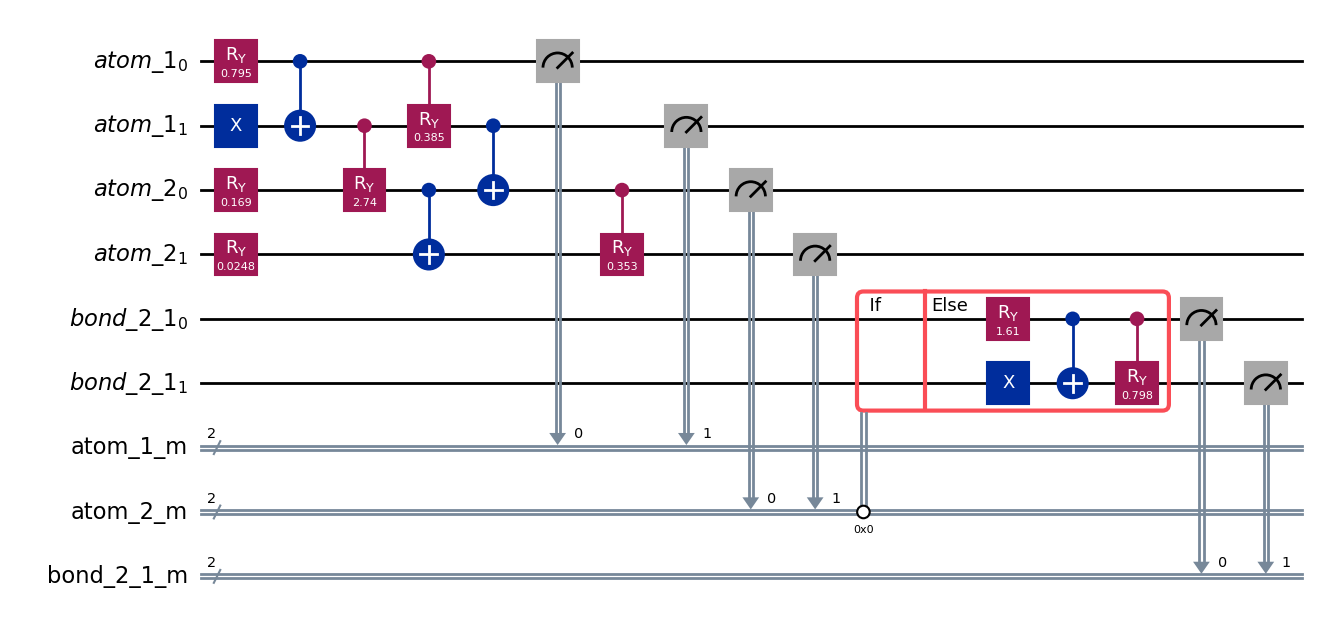

In [8]:
atom_1 = QuantumRegister(2, name="atom_1")
atom_2 = QuantumRegister(2, name="atom_2")
bond_2_1 = QuantumRegister(2, name="bond_2_1")

atom_1_measure = ClassicalRegister(2, name="atom_1_m")
atom_2_measure = ClassicalRegister(2, name="atom_2_m")
bond_2_1_measure = ClassicalRegister(2, name="bond_2_1_m")


circuit = QuantumCircuit(atom_1, atom_2, bond_2_1, atom_1_measure, atom_2_measure, bond_2_1_measure)

weight_vector = np.array([random.random() for _ in range(8)])

def controlled_ry(control:int, target:int, digit:float):
    circuit.cry(np.pi*digit, control, target)

circuit.ry(np.pi * weight_vector[0], 0)
circuit.x(1)
circuit.ry(np.pi * weight_vector[2], 2)
circuit.ry(np.pi * weight_vector[4], 3)
circuit.cx(0, 1)
controlled_ry(1, 2, weight_vector[3])
circuit.cx(2, 3)
controlled_ry(0, 1, weight_vector[1])
circuit.cx(1, 2)
controlled_ry(2, 3, weight_vector[5])

circuit.measure(atom_1, atom_1_measure)
circuit.measure(atom_2, atom_2_measure)
with circuit.if_test((atom_2_measure, 0)) as else_:
    pass
with else_:
    circuit.ry(np.pi * weight_vector[6], 4)
    circuit.x(5)
    circuit.cx(4,5)
    controlled_ry(4, 5, weight_vector[7])
circuit.measure(bond_2_1, bond_2_1_measure)

circuit.draw("mpl")

In [9]:
num_sample = 10000

transpiled_qc = pm.run(circuit)
sampler = Sampler(mode=backend)
sampler.options.default_shots = num_sample
job = sampler.run([transpiled_qc])

print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cyg0nyf01rbg008fjc1g


In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService

def get_token(file_path):
    with open(file_path) as f:
        data = f.read()
    token = data.strip()
    return token

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=get_token("../docs/ibmq_tokens.txt")
)
job = service.job('cyg0nyf01rbg008fjc1g')
job_result = job.result()

In [14]:
print(circuit.cregs)

[ClassicalRegister(2, 'atom_1_m'), ClassicalRegister(2, 'atom_2_m'), ClassicalRegister(2, 'bond_2_1_m')]


In [36]:
x = job_result[0].data.atom_1_m.get_counts()
print(x)

{'00': 347, '01': 1376, '10': 8058, '11': 219}


In [34]:
job_result[0].data.atom_2_m.get_bitstrings()

['01',
 '00',
 '10',
 '10',
 '10',
 '10',
 '00',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '00',
 '10',
 '10',
 '00',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '00',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '00',
 '00',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '00',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '00',
 '10',
 '10',
 '00',
 '10',
 '10',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '11',
 '10',
 '11',
 '10',
 '10',
 '10',
 '00',
 '10',
 '11',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '00',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',

In [77]:
num_heavy_atom = 9
num_parameters = int(8 + 3*(num_heavy_atom - 2) * (num_heavy_atom + 3) / 2)
qubit_register_dict = {"atom_1": QuantumRegister(2, name="atom_1"),
                       "atom_i": QuantumRegister(2, name="atom_i")}
for i in range(1, num_heavy_atom):
    qubit_register_dict.update({f"bond_{i}": QuantumRegister(2, name=f"bond_{i}")})

clbit_register_dict = {}
for i in range(1, num_heavy_atom+1):
    clbit_register_dict.update({f"atom_{i}_m": ClassicalRegister(2, name=f"atom_{i}_m")})
    for j in range(1, i):
        clbit_register_dict.update({f"bond_{i}_{j}_m": ClassicalRegister(2, name=f"bond_{i}_{j}_m")})

list(qubit_register_dict.values())
circuit = QuantumCircuit(*list(qubit_register_dict.values()), *list(clbit_register_dict.values()))

weight_vector = np.array([random.random() for _ in range(num_parameters)])

def controlled_ry(control:int, target:int, digit:float):
    circuit.cry(np.pi*digit, control, target)

def reset_q_register(circuit, q_register, measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(q_register[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(q_register[1])

def reset_block(circuit, heavy_atom_idx):
    reset_q_register(circuit, qubit_register_dict["atom_i"],  clbit_register_dict["atom_2_m"])
    for k in range(1, heavy_atom_idx):
        reset_q_register(circuit, qubit_register_dict[f"bond_{k}"],  clbit_register_dict[f"bond_{heavy_atom_idx}_{k}_m"])

def measure_bond_block(circuit, heavy_atom_idx):
    for k in range(1, heavy_atom_idx):
        circuit.measure(qubit_register_dict[f"bond_{k}"],  clbit_register_dict[f"bond_{heavy_atom_idx}_{k}_m"])

# first two atoms part
circuit.ry(np.pi * weight_vector[0], 0)
circuit.x(1)
circuit.ry(np.pi * weight_vector[2], 2)
circuit.ry(np.pi * weight_vector[4], 3)
circuit.cx(0, 1)
controlled_ry(1, 2, weight_vector[3])
circuit.cx(2, 3)
controlled_ry(0, 1, weight_vector[1])
circuit.cx(1, 2)
controlled_ry(2, 3, weight_vector[5])

circuit.measure(qubit_register_dict["atom_1"], clbit_register_dict["atom_1_m"])
circuit.measure(qubit_register_dict["atom_i"], clbit_register_dict["atom_2_m"])
with circuit.if_test((clbit_register_dict["atom_2_m"], 0)) as else_:
    pass
with else_:
    circuit.ry(np.pi * weight_vector[6], 4)
    circuit.x(5)
    circuit.cx(4,5)
    controlled_ry(4, 5, weight_vector[7])
circuit.measure(qubit_register_dict["bond_1"], clbit_register_dict["bond_2_1_m"])

used_part = 8
heavy_atom_idx = 3
# Third atom and recrusive part
for heavy_atom_idx in range(3, num_heavy_atom+1):
    # reset qubits for qubit reuse
    reset_block(circuit, heavy_atom_idx - 1) # heavy atom idx starts with 2
    with circuit.if_test((clbit_register_dict[f"atom_{heavy_atom_idx-1}_m"], 0)) as else_:
        pass
    with else_:
        circuit.ry(np.pi * weight_vector[used_part], qubit_register_dict["atom_i"][0])
        circuit.ry(np.pi * weight_vector[used_part+1], qubit_register_dict["atom_i"][1])
        controlled_ry(qubit_register_dict["atom_i"][0], qubit_register_dict["atom_i"][1], weight_vector[used_part+2])
    circuit.measure(qubit_register_dict["atom_i"], clbit_register_dict["atom_3_m"])
    with circuit.if_test((clbit_register_dict["atom_3_m"], 0)) as else_:
        pass
    with else_:
        for i in range(heavy_atom_idx-1):
            circuit.ry(np.pi * weight_vector[used_part+2+3*i+1], qubit_register_dict[f"bond_{i+1}"][1])
            controlled_ry(qubit_register_dict[f"bond_{i+1}"][1], qubit_register_dict[f"bond_{i+1}"][0], weight_vector[used_part+2+3*i+2]) # < 0.5
            controlled_ry(qubit_register_dict[f"bond_{i+1}"][0], qubit_register_dict[f"bond_{i+1}"][1], weight_vector[used_part+2+3*i+3]) # > 0.5

    measure_bond_block(circuit, heavy_atom_idx)
    used_part += 3*heavy_atom_idx


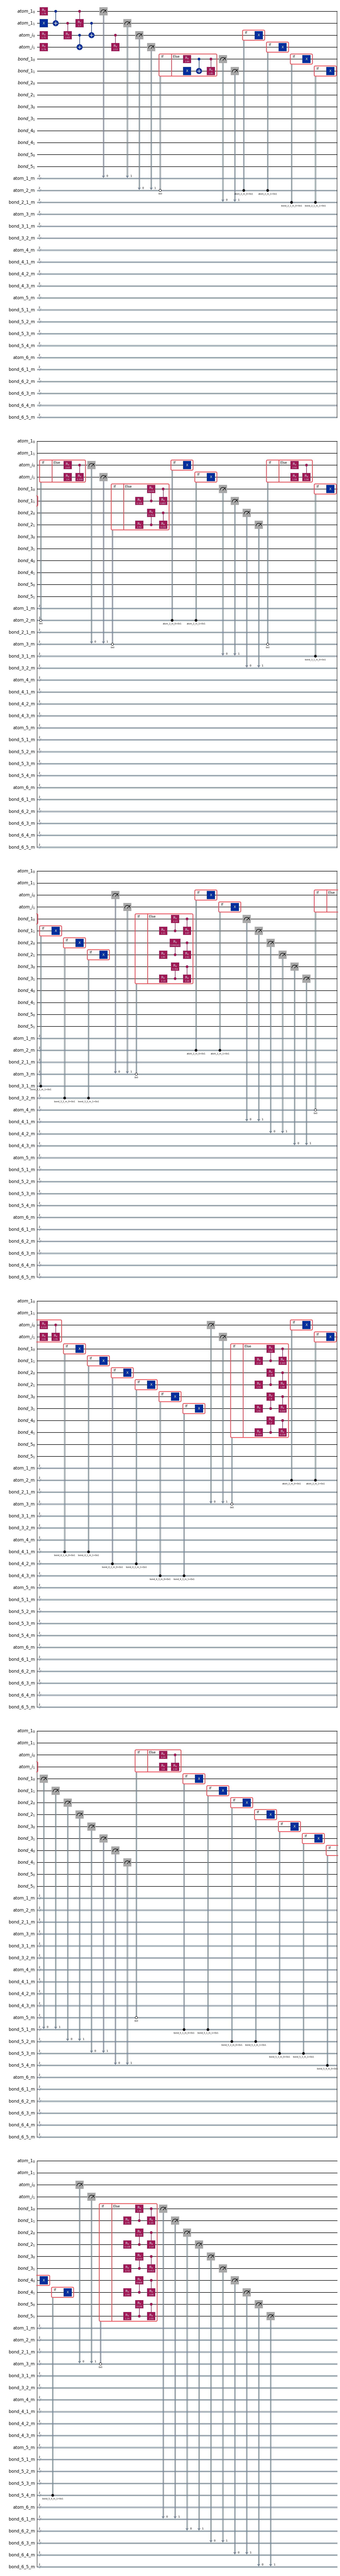

In [70]:
circuit.draw("mpl")

In [78]:
num_sample = 10000

transpiled_qc = pm.run(circuit)
sampler = Sampler(mode=backend)
sampler.options.default_shots = num_sample
job = sampler.run([transpiled_qc])

print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cyg3xt7cw2k00088y84g


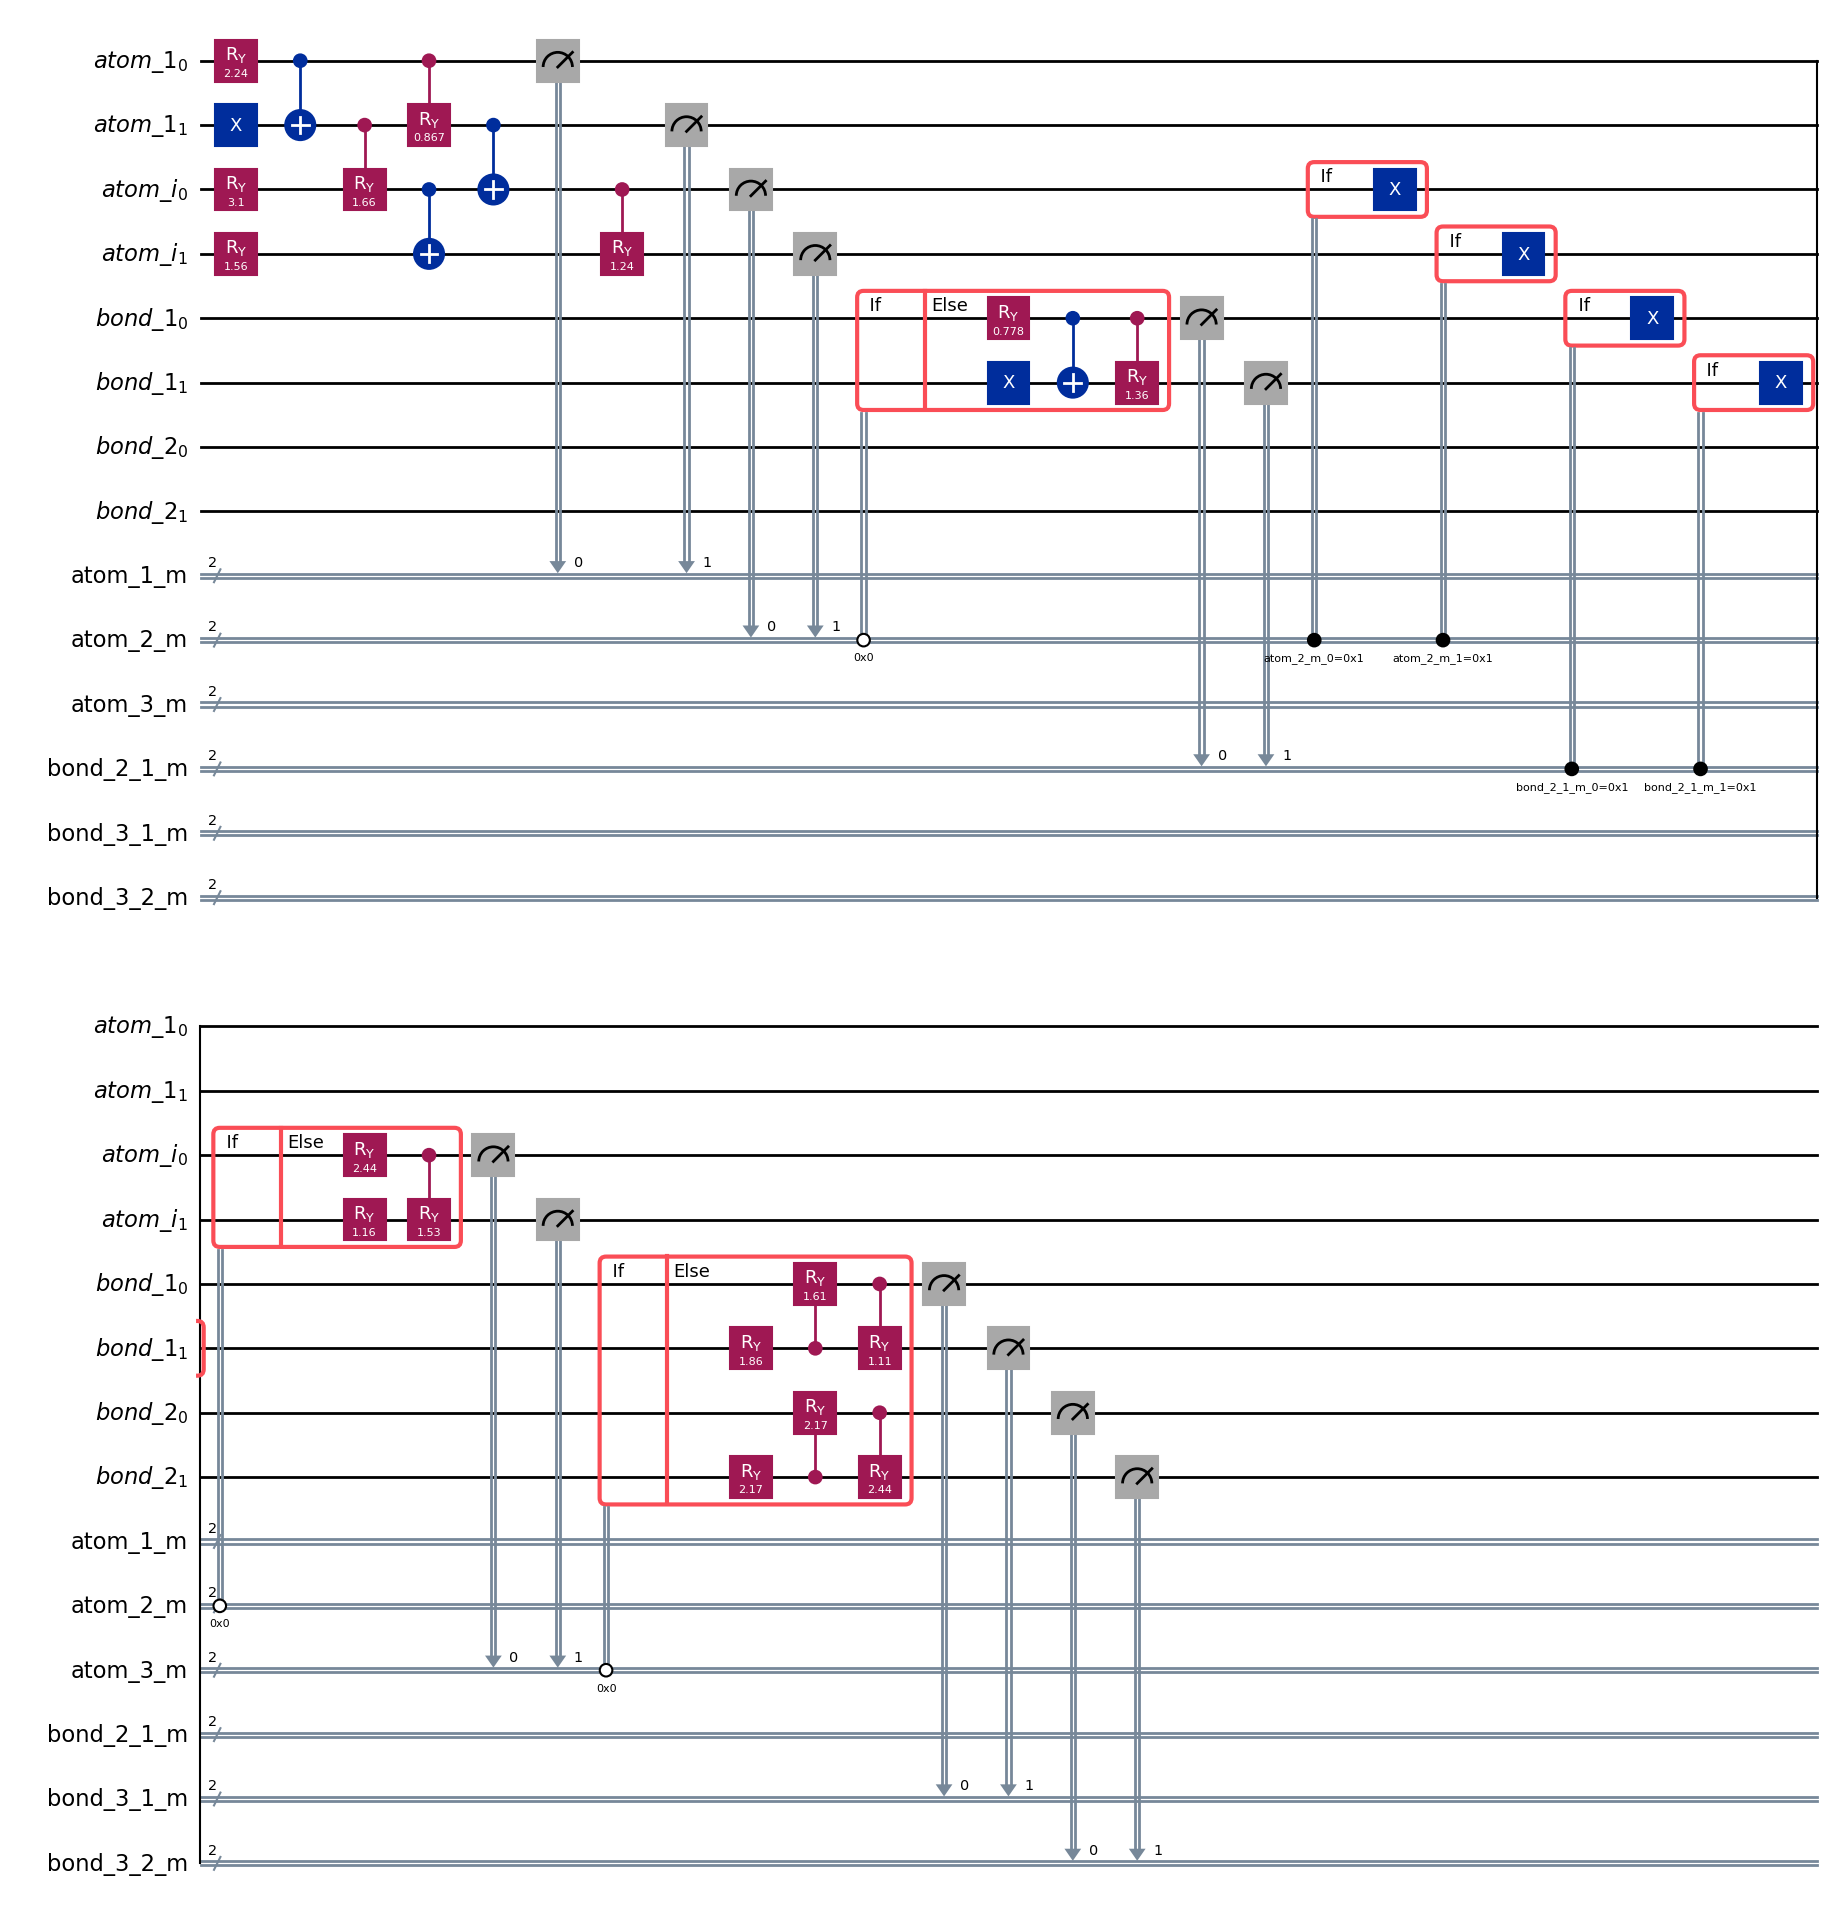

In [42]:
atom_1 = QuantumRegister(2, name="atom_1")
atom_i = QuantumRegister(2, name="atom_i")
bond_1 = QuantumRegister(2, name="bond_1")
bond_2 = QuantumRegister(2, name="bond_2")

atom_1_measure = ClassicalRegister(2, name="atom_1_m")
atom_2_measure = ClassicalRegister(2, name="atom_2_m")
atom_3_measure = ClassicalRegister(2, name="atom_3_m")
bond_2_1_measure = ClassicalRegister(2, name="bond_2_1_m")
bond_3_1_measure = ClassicalRegister(2, name="bond_3_1_m")
bond_3_2_measure = ClassicalRegister(2, name="bond_3_2_m")

circuit = QuantumCircuit(atom_1, atom_i, bond_1, bond_2, 
                         atom_1_measure, atom_2_measure, atom_3_measure, bond_2_1_measure, bond_3_1_measure, bond_3_2_measure)

weight_vector = np.array([random.random() for _ in range(17)])

def controlled_ry(control:int, target:int, digit:float):
    circuit.cry(np.pi*digit, control, target)

def reset_q_register(circuit, q_register,  measures):
    """Reset the controlling qubits if they are in |1>."""
    with circuit.if_test((measures[0], True)):
        circuit.x(q_register[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(q_register[1])

# first two atoms part
circuit.ry(np.pi * weight_vector[0], 0)
circuit.x(1)
circuit.ry(np.pi * weight_vector[2], 2)
circuit.ry(np.pi * weight_vector[4], 3)
circuit.cx(0, 1)
controlled_ry(1, 2, weight_vector[3])
circuit.cx(2, 3)
controlled_ry(0, 1, weight_vector[1])
circuit.cx(1, 2)
controlled_ry(2, 3, weight_vector[5])

circuit.measure(atom_1, atom_1_measure)
circuit.measure(atom_i, atom_2_measure)
with circuit.if_test((atom_2_measure, 0)) as else_:
    pass
with else_:
    circuit.ry(np.pi * weight_vector[6], 4)
    circuit.x(5)
    circuit.cx(4,5)
    controlled_ry(4, 5, weight_vector[7])
circuit.measure(bond_1, bond_2_1_measure)

# reset qubits for qubit reuse
reset_q_register(circuit, atom_i,  atom_2_measure)
reset_q_register(circuit, bond_1,  bond_2_1_measure)

# Third atom part
with circuit.if_test((atom_2_measure, 0)) as else_:
    pass
with else_:
    circuit.ry(np.pi * weight_vector[8], atom_i[0])
    circuit.ry(np.pi * weight_vector[9], atom_i[1])
    controlled_ry(atom_i[0], atom_i[1], weight_vector[10])
circuit.measure(atom_i, atom_3_measure)
with circuit.if_test((atom_3_measure, 0)) as else_:
    pass
with else_:
    circuit.ry(np.pi * weight_vector[11], bond_1[1])
    controlled_ry(bond_1[1], bond_1[0], weight_vector[12]) # < 0.5
    controlled_ry(bond_1[0], bond_1[1], weight_vector[13]) # > 0.5
    circuit.ry(np.pi * weight_vector[14], bond_2[1])
    controlled_ry(bond_2[1], bond_2[0], weight_vector[15]) # < 0.5
    controlled_ry(bond_2[0], bond_2[1], weight_vector[16]) # > 0.5
circuit.measure(bond_1, bond_3_1_measure)
circuit.measure(bond_2, bond_3_2_measure)

circuit.draw("mpl")

In [43]:
num_sample = 10000

transpiled_qc = pm.run(circuit)
sampler = Sampler(mode=backend)
sampler.options.default_shots = num_sample
job = sampler.run([transpiled_qc])

print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cyg1x5c7v8tg008x81b0


In [44]:
from qiskit_ibm_runtime import QiskitRuntimeService

def get_token(file_path):
    with open(file_path) as f:
        data = f.read()
    token = data.strip()
    return token

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=get_token("../docs/ibmq_tokens.txt")
)
job = service.job('cyg1x5c7v8tg008x81b0')
job_result = job.result()

In [48]:
job_result[0].data.atom_1_m.get_counts()

{'01': 5952, '10': 1867, '11': 2040, '00': 141}

In [ ]:
class DynamicCircuitBuilder():
    """ Dynamic circuit version of the molecule generation ansatz. It utilizes less qubits. """
    def __init__(self, num_heavy_atom:int, temperature:float=0.2, remove_bond_disconnection:bool=True, chemistry_constraint:bool=True):
        self.num_heavy_atom = num_heavy_atom
        self.temperature = temperature
        self.remove_bond_disconnection = remove_bond_disconnection
        self.chemistry_constraint = chemistry_constraint
        self.num_qubits = 4 + (num_heavy_atom-1) * 2
        self.num_clbits = num_heavy_atom * (num_heavy_atom + 1)
        self.qubits = QuantumRegister(self.num_qubits)
        self.clbits = ClassicalRegister(self.num_clbits, name="c")
        self.length_all_weight_vector = int(8 + (self.num_heavy_atom - 2)*(self.num_heavy_atom + 3) * 3 / 2)

    def initialize_quantum_circuit(self):
        self.qc = QuantumCircuit(self.qubits, self.clbits)

    def softmax_temperature(self, weight_vector):
        weight_vector /= self.temperature
        exps = np.exp(weight_vector)
        return exps / np.sum(exps)

    def controlled_ry(self, control:int, target:int, digit:float):
        self.qc.cry(np.pi*digit, control, target)

    def get_classical_register_by_name(self, name: str):
        for cr in self.qc.cregs:
            if cr.name == name:
                return cr
        else:
            raise ValueError(f"The name {name} is not found in classical registers.")

    def build_two_atoms(self, weight_vector: Union[List[float], np.ndarray]):
        assert len(weight_vector) == 8 # length of weight vector should be 8
        self.qc.ry(np.pi * weight_vector[0], 0)
        self.qc.x(1)
        self.qc.ry(np.pi * weight_vector[2], 2)
        self.qc.ry(np.pi * weight_vector[4], 3)
        self.qc.cx(0, 1)
        self.controlled_ry(1, 2, weight_vector[3])
        self.qc.cx(2, 3)
        self.controlled_ry(0, 1, weight_vector[1])
        self.qc.cx(1, 2)
        self.controlled_ry(2, 3, weight_vector[5])

        # measure atom 1 state:
        self.qc.measure(self.qubits[0:2], self.clbits[0:2])
        # measure atom 2 state and save:
        self.qc.measure(self.qubits[2:4], self.clbits[2:4])

        # Add a new atom existence ClassicalRegister:
        atom_existence_CR = ClassicalRegister(bits=self.clbits[2:4], name="atom_2_existence")
        self.qc.add_register(atom_existence_CR)
        with self.qc.if_test((atom_existence_CR, 0)) as else_:
            pass
        with else_:
            self.qc.ry(np.pi * weight_vector[6], 4)
            self.qc.x(5)
            self.qc.cx(4,5)
            self.controlled_ry(4, 5, weight_vector[7])

        self.qc.measure(self.qubits[4:6], self.clbits[4:6])

    def generate_quantum_circuit(self, all_weight_vector:Union[List[float], np.ndarray]=None, random_seed=0):
        random.seed(random_seed)
        self.initialize_quantum_circuit()
        # (1) generate weight vector
        if (type(all_weight_vector) == np.ndarray) or (type(all_weight_vector) == list):
            assert len(all_weight_vector) == self.length_all_weight_vector
            self.all_weight_vector = all_weight_vector
        else:
            self.all_weight_vector = np.array([random.random() for _ in range(self.length_all_weight_vector)])
            if self.chemistry_constraint and (self.num_heavy_atom>=3):
                used_part = 8
                for heavy_idx in range(3, self.num_heavy_atom+1):
                    used_part += 3 # atom type weight vector
                    num_fixed = heavy_idx-1
                    num_flexible = 2*num_fixed
                    bond_type_fixed_part = self.all_weight_vector[used_part: used_part+num_fixed]
                    self.all_weight_vector[used_part: used_part+num_fixed] = self.softmax_temperature(bond_type_fixed_part)
                    bond_type_flexible_part = self.all_weight_vector[used_part+num_fixed: used_part+num_fixed+num_flexible]
                    bond_type_flexible_part *= 0.5
                    bond_type_flexible_part += np.array([0, 0.5]*(heavy_idx-1))
                    self.all_weight_vector[used_part+num_fixed: used_part+num_fixed+num_flexible] = bond_type_flexible_part
                    used_part += num_fixed + num_flexible
        # (2) start to construct the quantum circuit
        self.build_two_atoms(self.all_weight_vector[0:8])
        return self.qc